# Bootstrapped Conv NN

A bootstrapped approach to domain adaptation for MNIST to USPS.

Author: @ysbecca

Credits go to:

- [Hvass-Labs](http://www.hvass-labs.org/) for the base CNN model for MNIST classification. Their CNN was deepened and adjusted to iteratively learn the USPS dataset.
- [Leo Pauly](https://github.com/leopauly) for the research in general and the initial code which loads the datasets.

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from datetime import timedelta
from importlib import reload
import math
import time

# Custom scripts.
import ysb
import dataset
import mnist_usps as mnus
import cnn_helper as cn

In [2]:
reload(mnus)
reload(dataset)
reload(cn)

<module 'cnn_helper' from '/home/ufaserv1_k/sc16rsmy/Domain-Adaptation/MNIST_USPS_Dataset/cnn_helper.py'>

Set parameters.

In [3]:
# CNN PARAMETERS
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

filter_size2 = 5         
num_filters2 = 16    

filter_size3 = 5         
num_filters3 = 32    

fc_size = 128             # Number of neurons in fully-connected layer.

# IMAGE PARAMETERS
img_size = 16             # Width and height in pixels.

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

## Load both datasets.

In [4]:
mnist_data, usps_data = dataset.read_datasets()

In [5]:
print("MNIST dataset:")
print("- Training-set:\t\t{}".format(mnist_data.train.num_images))
print("- Test-set:\t\t{}".format(mnist_data.test.num_images))
print("- Validation-set:\t{}".format(mnist_data.valid.num_images))

print("USPS dataset:")
print("- Training-set:\t\t{}".format(usps_data.train.num_images))
print("- Test-set:\t\t{}".format(usps_data.test.num_images))

MNIST dataset:
- Training-set:		49000
- Test-set:		14000
- Validation-set:	7000
USPS dataset:
- Training-set:		7439
- Test-set:		1859


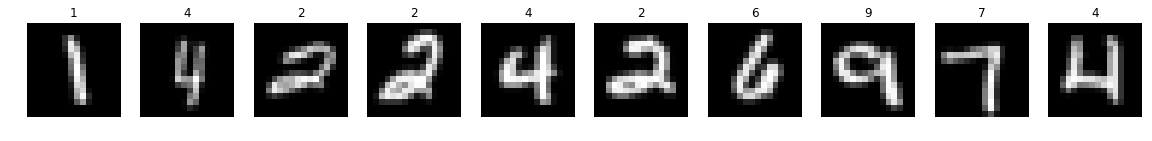

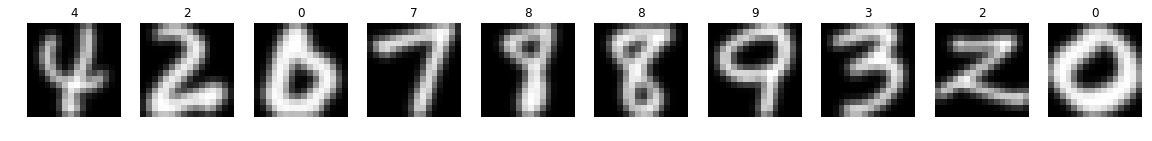

In [6]:
i = 0
ysb.show_labeled_patches_gray(mnist_data.train.images[i:(i+10)], mnist_data.train.cls[i:(i+10)])
ysb.show_labeled_patches_gray(usps_data.train.images[i:(i+10)], usps_data.train.cls[i:(i+10)])

## Train the CNN on MNIST.

First, set up the placeholders.

In [7]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1) # A placeholder only, so calculated instead of passed directly.

Build TensorFlow graph for a simple 3-layer CNN with max-pooling, ReLU and two fully-connected layers.

In [8]:
layer_conv1, weights_conv1 = \
    cn.new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True,
                   w_name="conv1_w")
layer_conv2, weights_conv2 = \
    cn.new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True,
                   w_name="conv2_w")
layer_conv3, weights_conv3 = \
    cn.new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True,
                   w_name="conv3_w")
layer_flat, num_features = cn.flatten_layer(layer_conv3)
layer_fc1 = cn.new_fc_layer(input=layer_flat,                # num_features = 128, from the flattened 3rd layer.
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         w_name="fc1_w")
layer_fc2 = cn.new_fc_layer(input=layer_fc1,                 # This is the classification layer.
                         num_inputs=fc_size,
                         num_outputs=num_classes,            # num_classes = 10
                         use_relu=False,
                         w_name="fc2_w")
y_pred = tf.nn.softmax(layer_fc2)                            # This is the softmax output prediction.
y_pred_cls = tf.argmax(y_pred, dimension=1)                  # The hard classification, with a threshold of 0.5.

In [9]:
# Cost to be reduced is the the cross entropy over all the images.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Now we create a new TensorFlow session and initialise the variables.

In [10]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 128
test_batch_size = 128

saver = tf.train.Saver()

Helper functions for running optimisation iterations and showing test accuracy.

In [43]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(dataset_train, num_iterations, silent=False):
    global total_iterations
    start_time = time.time()
    for i in range(total_iterations,
                   total_iterations + num_iterations):
        x_batch, y_true_batch = dataset_train.next_batch(train_batch_size)
        x_batch = x_batch.reshape(len(x_batch), img_size_flat)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 250 iterations.
        if i % 250 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            if not silent:
                msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
                print(msg.format(i + 1, acc))

    total_iterations += num_iterations

    end_time = time.time()
    time_dif = end_time - start_time
    if not silent:
        print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
def print_test_accuracy(dataset_test, show_confusion_matrix=True, quieter=False, silent=False):
    num_test = len(dataset_test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        curr_batch_size = j - i
        
        # Get the images and targets from the test-set between index i and j.
        images = dataset_test.images[i:j, :].reshape(curr_batch_size, img_size_flat)
        labels = dataset_test.labels[i:j, :]
        feed_dict = {x: images, y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    cls_true = dataset_test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum) / num_test

    msg = "Accuracy on test set: {0:.1%} ({1} / {2})"
    if not quieter:
        print(msg.format(acc, correct_sum, num_test))
    else:
        if not silent:
            print("{0:.1%}".format(acc))
    
    if show_confusion_matrix:
        cn.plot_confusion_matrix(cls_true, cls_pred=cls_pred)
    return acc

Train CNN.

In [12]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=False)

10.1%


0.10085714285714285

In [13]:
optimize(mnist_data.train, num_iterations=2000, silent=True)

Time usage: 0:00:10


In [14]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=False)

92.0%


0.9205

In [15]:
optimize(mnist_data.train, num_iterations=6000, silent=True)

Time usage: 0:00:28


In [16]:
print_test_accuracy(mnist_data.test, show_confusion_matrix=False)

96.8%


0.9680714285714286

Now we save the CNN model which has been trained on MNIST.

In [17]:
saver.save(sess=session, save_path='checkpoints/')

'checkpoints/'

## Now learn USPS dataset

Now test on USPS test set, then run the CNN on the entire training set (we treat the training set as if it is completely unlabeled) and save softmax outputs.

63.7%
[[234   0   5  19   0  14   0   0  43   0]
 [  0  55   0   2   0   0   0   0 209   0]
 [  0   0 112  44   0   1   1   0  13   0]
 [  0   0   1 164   0   2   0   0  13   1]
 [  0   0   0   2  93   1   8   2  11  39]
 [  0   0   1  36   0 106   1   0   9   0]
 [  0   0   1   0   0   8 147   0  13   0]
 [  1   1  12  81   0   0   0  43  22   9]
 [  0   0   0   1   0   0   0   0 139   0]
 [  0   0   0  13   8   0   0   1  26  91]]


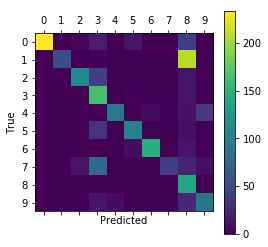

0.6369015599784831

In [18]:
print_test_accuracy(usps_data.test, show_confusion_matrix=True)

In [26]:
def retrieve_predictions(dataset):
    ''' Retrieves the probabilities (not predicted classes) on the given DataSet object. '''
    num_test = len(dataset.images)

    # Allocate an array for the class probabilities which will be calculated in batches and added
    # onto this array; this first element is a dummy to maintain shape as we will add in batches.
    cls_prob = np.zeros(shape=(1, num_classes), dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)
        curr_batch_size = j - i
        images = dataset.images[i:j, :].reshape(curr_batch_size, img_size_flat)
        labels = dataset.labels[i:j, :]
        feed_dict = {x: images, y_true: labels}

        # Save the softmax output.
        cls_prob = np.concatenate((cls_prob, session.run(y_pred, feed_dict=feed_dict)), axis=0)
        i = j
    
    cls_prob = np.delete(cls_prob, 0, 0) # Remove the first dummy element now.
    return cls_prob

## Experimenting with different thresholds, number of iterations, & threshold rates.

Remember to reset the CNN model back to the checkpoint before each new experiment, as well as re-designating the dataset so that all MNIST images are training images, and the USPS set is divided into test (labelled) and train (unlabelled).

In [69]:
saver.restore(sess=session, save_path='checkpoints/')
data = dataset.generate_combined_dataset(mnist_data, usps_data)

INFO:tensorflow:Restoring parameters from checkpoints/


### Experiment 1: repeated iterations of taking the top 0.99.

In [70]:
bootstrap_iterations = 75
exp1_acc = []
exp1_adds = []

print("-- Experiment 1 --")

for i in range(bootstrap_iterations):
    # print("Round " + str(i) + ":", end=" ")

    usps_train_preds = retrieve_predictions(data.usps_train)
    selected = cn.split_by_threshold(0.99, usps_train_preds, silent=True)
    if np.count_nonzero(selected) >= data.train.num_images or np.count_nonzero(selected) == 0:
        print("Ending iterations early.")
        break
        
    exp1_adds.append(np.count_nonzero(selected))
    data.train.add_to_set(selected, data.usps_train, usps_train_preds)
    data.usps_train.remove_from_set(selected)
    
    optimize(data.train, num_iterations=1000, silent=True)
    exp1_acc.append(print_test_accuracy(data.test, show_confusion_matrix=False, quieter=True, silent=True))

-- Experiment 1 --
Ending iterations early.


In [71]:
print("Best percent accuracy: " + str(np.max(exp1_acc)))

Best percent accuracy: 0.737493275955


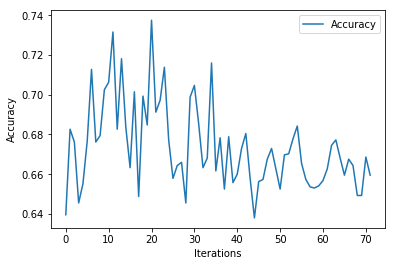

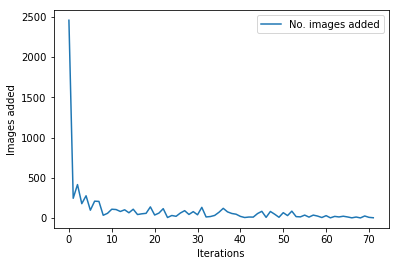

In [73]:
ysb.plot_with_legend(np.arange(len(exp1_acc)), [exp1_acc], ["Accuracy"], "Iterations", "Accuracy")
ysb.plot_with_legend(np.arange(len(exp1_adds)), [exp1_adds], ["No. images added"], "Iterations", "Images added")

### Experiment 2: gradually decrease the softmax threshold requirement for re-labelling.

In [74]:
saver.restore(sess=session, save_path='checkpoints/')
data = dataset.generate_combined_dataset(mnist_data, usps_data)

INFO:tensorflow:Restoring parameters from checkpoints/


In [75]:
exp2_acc = []
exp2_adds = []

print("-- Experiment 2 --")

for i in range(bootstrap_iterations):
    # print("Round " + str(i) + ":", end=" ")
    usps_train_preds = retrieve_predictions(data.usps_train)
    threshold = 0.99 - i*0.0005
    selected = cn.split_by_threshold(threshold, usps_train_preds, silent=True)
    if np.count_nonzero(selected) >= data.train.num_images or np.count_nonzero(selected) == 0:
        print("Ending iterations early.")
        break
    exp2_adds.append(np.count_nonzero(selected))
    data.train.add_to_set(selected, data.usps_train, usps_train_preds)
    data.usps_train.remove_from_set(selected)
    
    optimize(data.train, num_iterations=1000, silent=True)
    exp2_acc.append(print_test_accuracy(data.test, show_confusion_matrix=False, quieter=True, silent=True))

-- Experiment 2 --
Ending iterations early.


In [76]:
print("Best percent accuracy: " + str(np.max(exp2_acc)))

Best percent accuracy: 0.711672942442


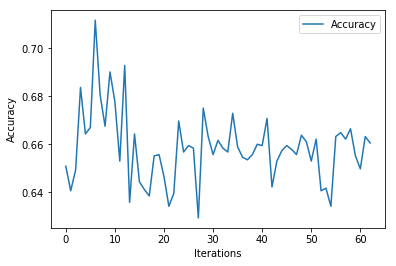

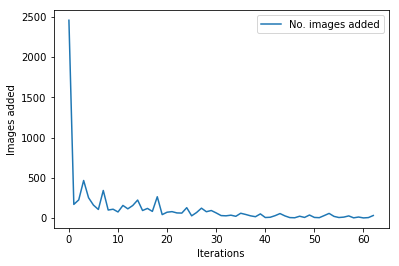

In [77]:
ysb.plot_with_legend(np.arange(len(exp2_acc)), [exp2_acc], ["Accuracy"], "Iterations", "Accuracy")
ysb.plot_with_legend(np.arange(len(exp2_adds)), [exp2_adds], ["No. images added"], "Iterations", "Images added")

### Experiment 3: gradually lower the threshold after the peak performance (from experiment 1).

In [78]:
saver.restore(sess=session, save_path='checkpoints/')
data = dataset.generate_combined_dataset(mnist_data, usps_data)

INFO:tensorflow:Restoring parameters from checkpoints/


In [79]:
exp3_acc = []
exp3_adds = []

print("-- Experiment 3 --")
peak_iteration = np.argmax(exp1_acc)
j = 0

for i in range(bootstrap_iterations):
    # print("Round " + str(i) + ":", end=" ")
    usps_train_preds = retrieve_predictions(data.usps_train)
    threshold = 0.99
    if i >= peak_iteration:
        threshold -= j
        j += 0.0005
        
    selected = cn.split_by_threshold(threshold, usps_train_preds, silent=True)
    if np.count_nonzero(selected) >= data.train.num_images or np.count_nonzero(selected) == 0:
        print("Ending iterations early.")
        break
    
    exp3_adds.append(np.count_nonzero(selected))
    data.train.add_to_set(selected, data.usps_train, usps_train_preds)
    data.usps_train.remove_from_set(selected)
    
    optimize(data.train, num_iterations=1000, silent=True)
    exp3_acc.append(print_test_accuracy(data.test, show_confusion_matrix=False, quieter=True, silent=True))

-- Experiment 3 --


In [80]:
print("Best percent accuracy: " + str(np.max(exp3_acc)))

Best percent accuracy: 0.720817643895


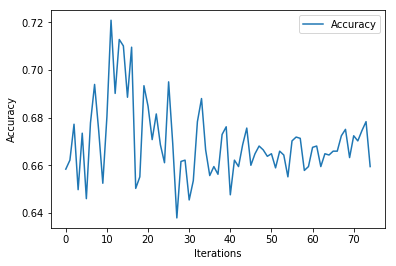

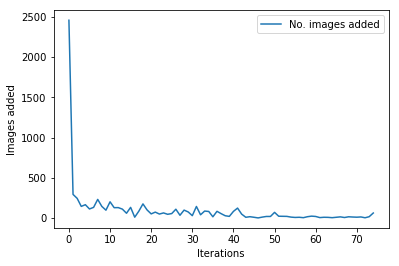

In [81]:
ysb.plot_with_legend(np.arange(len(exp3_acc)), [exp3_acc], ["Accuracy"], "Iterations", "Accuracy")
ysb.plot_with_legend(np.arange(len(exp3_adds)), [exp3_adds], ["No. images added"], "Iterations", "Images added")

## Comparison from all three experiments.

In [82]:
x_range = min(len(exp1_acc), len(exp2_acc), len(exp3_acc))

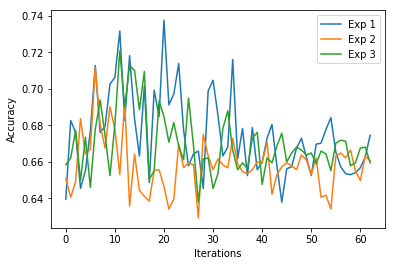

In [83]:
ysb.plot_with_legend(np.arange(x_range), [exp1_acc[:x_range], exp2_acc[:x_range], exp3_acc[:x_range]], ["Exp 1", "Exp 2", "Exp 3"], "Iterations", "Accuracy")

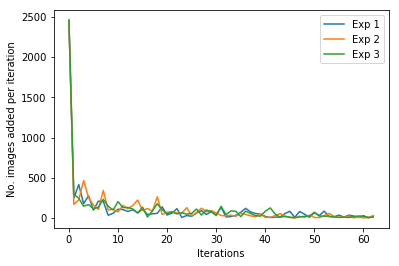

In [84]:
ysb.plot_with_legend(np.arange(x_range), [exp1_adds[:x_range], exp2_adds[:x_range], exp3_adds[:x_range]], ["Exp 1", "Exp 2", "Exp 3"], "Iterations", "No. images added per iteration")

## Close TensorFlow session

Releases all resources! Run only when prepared to lose saved CNN model.

In [85]:
session.close()